# Introduction

The prices of HDB flats in Singapore is of interest to most Singaporeans as it is the most affordable and accessible form of housing for young adults, who wish to move out of their parent's. There are 2 ways to go about obtaining one: ballot for a new flat from HDB (opportunity to buy at a subsidised rate!), or get a resale flat on the open market (some subsidies, but ho-hum). There are no regulations to fix prices (ceiling or floor) for resale flats, so transaction prices are entirely up to buyers and sellers. They may value a flat based on objective characteristics (area, floor level) or subjective features (well-maintained, good location). Having been in a position shopping for a flat, the question of 'Is this a fair price to pay for the flat?' came up repeatedly and I resorted to checking the recent resale transactions around the area (a manual version of k-nearest neighbours, if you will) to decide the fair value of a flat that I am interested in. 

The Singapore government launched a portal, Data.gov.sg, in an effort to make public data more accessible and I found that HDB resale transactions going back all the way to 1990 are available in a csv format right [here]( https://data.gov.sg/dataset/resale-flat-prices?resource_id=83b2fc37-ce8c-4df4-968b-370fd818138b).

In this workbook, I will detail my steps to creating a linear regression model using the public information available in these csv files.

# Getting files and combining them

Obviously the first task will be to get the files by downloading it off the site, data.gov.sg does provide an API for queries but since we just after the csv files available at the click of a button, why bother hacking through all the API documentations when you can do it the easy way? So download all of them in 1 zip file and unzip it!

Now you got them, let's see what we're working with here!

In [1]:
# Getting all the necessary packages
import numpy as np
import pandas as pd

In [2]:
df1990 = pd.read_csv('resale_data/resale-flat-prices-based-on-approval-date-1990-1999.csv')
df1990.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [3]:
df1990.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64

No missing data, very nice! Ok now you've done it for 1, and the data looks good and clean, let's go do it for the other 4!

In [4]:
df2000 = pd.read_csv('resale_data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
df2012 = pd.read_csv('resale_data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df2015 = pd.read_csv('resale_data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
df2017 = pd.read_csv('resale_data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df2017.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


### Looks alright, but note that there's an extra column: 'remaining_lease'. Now this is going to be a problem potentially...

solution: we'll add the remaining_lease column to the other years as we have the date the lease commences, assuming a 99 year lease (most HDBs are with some exceptional 60 year ones). 
``` remaining_lease = lease commence + 99 - year of transaction```

Lets find out which years we need to impute the 'remaining_lease' columns

In [5]:
df_list = [df1990, df2000, df2012, df2015, df2017]
for df in df_list:
    if 'remaining_lease' not in df.columns:
        print(df.iloc[1,:])

month                           1990-01
town                         ANG MO KIO
flat_type                        1 ROOM
block                               309
street_name            ANG MO KIO AVE 1
storey_range                   04 TO 06
floor_area_sqm                       31
flat_model                     IMPROVED
lease_commence_date                1977
resale_price                       6000
Name: 1, dtype: object
month                           2000-01
town                         ANG MO KIO
flat_type                        3 ROOM
block                               174
street_name            ANG MO KIO AVE 4
storey_range                   04 TO 06
floor_area_sqm                       61
flat_model                     Improved
lease_commence_date                1986
resale_price                     144000
Name: 1, dtype: object
month                           2012-03
town                         ANG MO KIO
flat_type                        2 ROOM
block                             

Here we see, only df1990, 2000 and 2012 does not have the 'remaining_lease' column, let's create one for them. 

In [6]:
for df in df_list[0:3]:
    df['year'] = df['month'].str[:4] # transaction dates are saved as a string, with the years in the first 4 columns
    df['year'] = df['year'].astype(int)
    df['remaining_lease'] = df['lease_commence_date'] + 99 - df['year']
df2000.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,2000,85
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,2000,85
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,2000,75
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,2000,75
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,2000,75


Everythign looks fine here, we're going to drop the 'years' column to avoid future problems when we combine the dataframes!

In [7]:
for df in df_list[0:3]:
    df.drop(columns=['year'],inplace = True)
df2000.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0,85
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0,85
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0,75
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0,75
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0,75


In [8]:
df2017.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


For transactions from 2017, remaining leases are recorded as years and months, we'll just drop the months by slicing the first 2 chars (years) off the string since it's easier to do and probably not much data loss here.

In [9]:
df2017['remaining_lease'] = df2017['remaining_lease'].str[:2]
df2017['remaining_lease'] = df2017['remaining_lease'].astype(int)

In [10]:
# Just to check that there aren't any weird values sliced off!
df2017['remaining_lease'].unique()

array([61, 60, 62, 63, 58, 59, 93, 94, 78, 70, 67, 68, 56, 66, 65, 69, 64,
       83, 87, 71, 92, 54, 82, 75, 55, 74, 72, 80, 86, 79, 53, 57, 52, 51,
       95, 90, 81, 85, 84, 77, 88, 49, 50, 89, 73, 48, 76, 91, 96, 47, 46,
       45, 97])

# Now we're ready to combine the data!

In [11]:
transactions = pd.concat(df_list)
transactions.tail(10) #check random rows of the data to see if data has been combined successfully!

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
80364,2020-09,YISHUN,5 ROOM,504D,YISHUN ST 51,13 TO 15,113.0,Improved,2016,630000.0,94
80365,2020-09,YISHUN,5 ROOM,504B,YISHUN ST 51,07 TO 09,112.0,Improved,2016,538000.0,94
80366,2020-09,YISHUN,5 ROOM,505B,YISHUN ST 51,04 TO 06,113.0,Improved,2016,540000.0,94
80367,2020-09,YISHUN,5 ROOM,637,YISHUN ST 61,10 TO 12,121.0,Improved,1987,459988.0,66
80368,2020-09,YISHUN,5 ROOM,626,YISHUN ST 61,04 TO 06,121.0,Improved,1987,460000.0,65
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,Improved,1987,440000.0,66
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,Improved,1987,458000.0,65
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,Improved,1987,490000.0,66
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,Maisonette,1987,558000.0,66
80373,2020-09,YISHUN,EXECUTIVE,387,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,555000.0,66


In [12]:
transactions.isna().sum() #check if any null data exists, indicates something went wrong in the concatenation!

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
dtype: int64

In [13]:
transactions.shape

(826581, 11)

We have 826581 transactions and 11 features, from which to make a simple regression model!

**A few considerations before starting to fit a regression model:**

* Resale prices have grown tremendously from 1990s (start of data set), how will I account for the price changes due to inflation? 
* Location is one of the obvious factor for prices, we have 2 features, street name and block that code for this property, but working with block and street names are always tricky and users might key in the same value differently e.g. Yishun Street v.s. Yishun St.
* Are there differences in data entry format that could same data to be interpreted differently?
* Storey ranges: traditionally, the higher the floor, the better, how should I best represent them?

Ideas to address issues:
* Transaction dates are included, if this is included as a feature, inflation should be addressed by this feature
* I could concatenate the block and street names to form a complete address, but in order to make it easy to use, I'll try converting it to a postal code (long side story for another post)
* Explore the data and standardise/replace data entry format!
* Data provided is already binned, let's convert them into ordinal features

In [14]:
transactions['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

Looks like a simple replacement of 'MULTI-GENERATION' with ''MULTI GENERATION' will do the trick!

In [15]:
flat_type_dup = {'MULTI-GENERATION' : 'MULTI GENERATION'}
transactions.replace({'flat_type':flat_type_dup}, inplace = True)
transactions['flat_type'].unique() #Done!

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION'], dtype=object)

In [16]:
transactions['flat_model'].unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'Improved', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Simplified', 'Model A-Maisonette',
       'Maisonette', 'Multi Generation', 'Adjoined flat',
       'Premium Apartment', 'Terrace', 'Improved-Maisonette',
       'Premium Maisonette', '2-room', 'Model A2', 'DBSS', 'Type S1',
       'Type S2', 'Premium Apartment Loft'], dtype=object)

Seems like it's a classic upper/lower case mismatch during data entry! Let's just change it all to upper case!

In [17]:
transactions['flat_model'] = transactions['flat_model'].str.upper()
transactions['flat_model'].unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'ADJOINED FLAT', 'PREMIUM MAISONETTE',
       'MODEL A2', 'DBSS', 'TYPE S1', 'TYPE S2', 'PREMIUM APARTMENT LOFT'],
      dtype=object)

## Duplicates removed!

In [18]:
storey_ranges = transactions['storey_range'].unique()
storey_ranges.sort()
storey_ranges

array(['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09',
       '10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20',
       '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30',
       '28 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40',
       '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

Problem: These are in overlapping bins! 01-03 and 01-05?! Also it goes all the way to 51? I have a feeling distributions of flats above 15 are going to be tiny?

In [19]:
transactions['storey_range'].value_counts()

04 TO 06    209705
07 TO 09    189109
01 TO 03    168985
10 TO 12    160250
13 TO 15     52212
16 TO 18     19449
19 TO 21      9422
22 TO 24      6053
01 TO 05      2700
25 TO 27      2544
06 TO 10      2474
11 TO 15      1259
28 TO 30      1049
34 TO 36       267
16 TO 20       265
31 TO 33       265
37 TO 39       255
40 TO 42       132
21 TO 25        92
26 TO 30        39
46 TO 48        21
43 TO 45        16
49 TO 51         9
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64

Maybe we should bin levels above 31 together? Side note: you can visualize this with a histogram too with .hist()
Back to our storey ranges, we have 2 tasks:

* remove the overlapping ones by joining them
* bin all the levels 31 and above

There's probably a smart way of doing this by algo, but there aren't that many groups, so I'm going to do this manually.

In [20]:
transactions.loc[transactions['storey_range']=='01 TO 03','storey_range'] = '01 TO 05'
transactions.loc[transactions['storey_range']=='04 TO 06','storey_range'] = '01 TO 05'
transactions.loc[transactions['storey_range']=='07 TO 09','storey_range'] = '06 TO 10'
transactions.loc[transactions['storey_range']=='10 TO 12','storey_range'] = '11 TO 15'
transactions.loc[transactions['storey_range']=='13 TO 15','storey_range'] = '11 TO 15'
transactions.loc[transactions['storey_range']=='16 TO 18','storey_range'] = '16 TO 20'
transactions.loc[transactions['storey_range']=='19 TO 21','storey_range'] = '16 TO 20'
transactions.loc[transactions['storey_range']=='22 TO 24','storey_range'] = '21 TO 25'
transactions.loc[transactions['storey_range']=='25 TO 27','storey_range'] = '26 TO 30'
transactions.loc[transactions['storey_range']=='28 TO 30','storey_range'] = '26 TO 30'

In [21]:
storey_ranges = transactions['storey_range'].unique()
storey_ranges.sort()
storey_ranges

array(['01 TO 05', '06 TO 10', '11 TO 15', '16 TO 20', '21 TO 25',
       '26 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40',
       '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

In [22]:
idx = list(storey_ranges).index('31 TO 33')
idx

6

In [23]:
# hacky way of binning levels above 31
for i in range(idx,15):
    storey = storey_ranges[i]
    transactions.loc[transactions['storey_range'] == storey, 'storey_range'] = '31 TO 51'
transactions['storey_range'].unique()
# Looks good!

array(['11 TO 15', '01 TO 05', '06 TO 10', '16 TO 20', '26 TO 30',
       '21 TO 25', '31 TO 51'], dtype=object)

Now that it's cleaned, let's give it make it an ordinal feature, as we know that higher level units are more desirable than lower ones (for a variety of reasons), so higher > lower!

In [24]:
storey_ranges = transactions['storey_range'].unique()
storey_ranges.sort()
storey_converter = {v:k for k,v in enumerate(storey_ranges)}
storey_converter

{'01 TO 05': 0,
 '06 TO 10': 1,
 '11 TO 15': 2,
 '16 TO 20': 3,
 '21 TO 25': 4,
 '26 TO 30': 5,
 '31 TO 51': 6}

In [25]:
# Replacing the data
transactions.replace({"storey_range":storey_converter},inplace=True)
transactions.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,2,31.0,IMPROVED,1977,9000.0,86
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,0,31.0,IMPROVED,1977,6000.0,86
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,2,31.0,IMPROVED,1977,8000.0,86
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,1,31.0,IMPROVED,1977,6000.0,86
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,0,73.0,NEW GENERATION,1976,47200.0,85


In [26]:
transactions['storey_range'].value_counts()

0    381390
2    213721
1    191583
3     29136
4      6145
5      3632
6       974
Name: storey_range, dtype: int64

## Now to address the fact that the transactions are over 30 years and the date of transaction undeniably has an impact on the resale price!

However, SKlearn does not accept date/time formats as features so we are going to have to convert it to an ordinal number from day 0, day 0 being the 1st transaction date, January 1990

In [27]:
transactions.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,2,31.0,IMPROVED,1977,9000.0,86
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,0,31.0,IMPROVED,1977,6000.0,86
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,2,31.0,IMPROVED,1977,8000.0,86
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,1,31.0,IMPROVED,1977,6000.0,86
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,0,73.0,NEW GENERATION,1976,47200.0,85


In [28]:
transactions['month'] = pd.to_datetime(transactions['month'])
firstdate = transactions.iloc[0,0]
transactions['tx_day'] = transactions['month'] - firstdate
transactions.sample(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,tx_day
101137,2002-10-01,CHOA CHU KANG,3 ROOM,111,TECK WHYE LANE,1,73.0,MODEL A,1989,132000.0,86,4656 days
74252,2002-01-01,HOUGANG,3 ROOM,617,HOUGANG AVE 8,1,64.0,SIMPLIFIED,1986,131800.0,83,4383 days
130495,2003-10-01,HOUGANG,4 ROOM,19,HOUGANG AVE 3,0,98.0,NEW GENERATION,1978,240000.0,74,5021 days
20971,2016-03-01,JURONG EAST,4 ROOM,52,TEBAN GDNS RD,2,83.0,SIMPLIFIED,1987,310000.0,70,9556 days
22993,2018-03-01,BISHAN,5 ROOM,273B,BISHAN ST 24,1,120.0,DBSS,2011,985000.0,92,10286 days


In [29]:
# We can just go ahead and convert the data type to an integer for easier feeding in to the learning model!
transactions['tx_day'] = transactions['tx_day'].dt.days.astype(int)
transactions.sample(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,tx_day
89733,2002-06-01,HOUGANG,3 ROOM,689,HOUGANG ST 61,0,74.0,MODEL A,1987,155000.0,84,4534
256769,2008-03-01,HOUGANG,5 ROOM,302,HOUGANG AVE 5,0,133.0,MODEL A,1983,346000.0,74,6634
311920,2010-01-01,WOODLANDS,5 ROOM,881,WOODLANDS ST 82,2,123.0,IMPROVED,1996,348000.0,85,7305
270118,1999-08-01,GEYLANG,3 ROOM,57,CIRCUIT RD,1,56.0,STANDARD,1969,107000.0,69,3499
75763,2020-08-01,BUKIT BATOK,4 ROOM,393,BT BATOK WEST AVE 5,1,92.0,MODEL A,2004,408000.0,83,11170


## We're almost at the end of feature engineering, just the address to go. 
The plan is to combine the block + street name to obtain the full address, and with the full address, obtain a postal code. However there aren't any ready database for us to obtain postal codes from an address, so we're going to have to scrape it from the Singpost website.

In [30]:
import time
import requests
from bs4 import BeautifulSoup
#import required packages for scraping

In [31]:
transactions['full_address'] = transactions['block'] + ' ' + transactions['street_name']
all_addresses = transactions['full_address'].unique()
print('There are {} addresses'.format(len(all_addresses)))
transactions.sample(5)

There are 9279 addresses


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,tx_day,full_address
207107,2006-05-01,JURONG WEST,3 ROOM,516,JURONG WEST ST 52,0,74.0,MODEL A,1984,163000.0,77,5964,516 JURONG WEST ST 52
22779,2013-03-01,BUKIT MERAH,3 ROOM,63,TELOK BLANGAH HTS,0,73.0,NEW GENERATION,1976,438000.0,62,8460,63 TELOK BLANGAH HTS
75851,1994-08-01,MARINE PARADE,3 ROOM,33,MARINE CRES,2,65.0,IMPROVED,1975,114000.0,80,1673,33 MARINE CRES
258787,2008-04-01,CHOA CHU KANG,EXECUTIVE,559,CHOA CHU KANG NTH 6,1,146.0,APARTMENT,1996,428000.0,87,6665,559 CHOA CHU KANG NTH 6
23358,2013-03-01,QUEENSTOWN,4 ROOM,22,QUEEN'S CL,2,106.0,MODEL A,1996,645000.0,82,8460,22 QUEEN'S CL


Looks pretty good! We have 9279 addresses to scrape from the singpost website, should be the most hits they get in a day. HAHA.

In [32]:
# Here's the function I used to obtain the postal codes from the HDB addresses in this dataset.
def address_to_Pcode(building, address):
    '''
    Uses requests and beautifulsoup to post an address to singpost website to obtain the postal code of said address.
    '''
    url = "https://www.singpost.com/find-postal-code"
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'}
    data = {'building': building,
            'street_name': address,
            'op': 'Find',
           }
    r = requests.post(url, data = data, headers = headers)
    if r.status_code != 200:
        print('Request unsuccessful')
        return building+address
    else:
        soup = BeautifulSoup(r.text,'html.parser')
        datatable = soup.find(id="datatable-1")
        if datatable:
            postal_code = datatable.td.find_all('p')[1].get_text()
            return postal_code
        else:
            return 'Address not found.'

def get_postal_codes(file, all_addresses,n):
    '''
    file: dictionary containing obtained addresses and postal codes
    all_addresses: list of unique addresses/block numbers
    n: number of codes to retrieve per run
    returns dictionary of addresses & list of failed addresses in a tuple
    '''
    if type(file) != dict:
        raise TypeError('file should be a dictionary.')
    postal_code_dict = file
    failed_addresses = []
    count = 0
    for add in all_addresses:
        if count >= n:
            break
        if add not in postal_code_dict:
            block, address = add.split(maxsplit = 1)
            postal_code = address_to_Pcode(block, address)
            if len(postal_code)!=6:
                print('Address failed')
                postal_code_dict[add] = postal_code # adds 
                failed_addresses.append(add)
            else:
                print(add,'successful, adding to dictionary... count is:',count)
                postal_code_dict[add] = postal_code
                count += 1
            time.sleep(1) # be sure to let your function sleep for a bit, in case the server bans you!
        else: continue
    return postal_code_dict, failed_addresses

# I changed this to a markdown so I don't run this code again, but you can if you want to scrape the postal codes yourself.
```python
postal_code_dict, cur_failed_addresses = get_postal_codes(postal_code_dict,all_addresses,len(all_addresses))
failed_addresses.extend(cur_failed_addresses)
```
I saved the address/postalcode dictionary so I won't have to go through the hassle of scraping the website, just in case if I need it again.

In [33]:
def pickleRick(file,file_name):
    import pickle
    outfile = open(file_name,'wb')
    pickle.dump(file,outfile)
    outfile.close()

def unpickleRick(file_name):
    import pickle
    infile = open(file_name, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

#Don't mind the Rick & Morty references!

In [34]:
postal_code_dict = unpickleRick('postal_code.pickle')

In [35]:
# time to map our addresses to postal codes!
transactions['postalcode'] = transactions['full_address'].map(postal_code_dict)
transactions.sample(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,tx_day,full_address,postalcode
44375,2001-04-01,BUKIT MERAH,4 ROOM,105,BT PURMEI RD,0,93.0,NEW GENERATION,1983,232500.0,81,4108,105 BT PURMEI RD,090105
33647,2013-10-01,TOA PAYOH,4 ROOM,143,LOR 2 TOA PAYOH,3,90.0,MODEL A,2002,623000.0,88,8674,143 LOR 2 TOA PAYOH,310143
141051,2004-02-01,BISHAN,5 ROOM,288,BISHAN ST 24,3,123.0,PREMIUM APARTMENT,1998,460000.0,93,5144,288 BISHAN ST 24,570288
270107,1999-08-01,GEYLANG,3 ROOM,83,MACPHERSON LANE,0,64.0,STANDARD,1968,108000.0,68,3499,83 MACPHERSON LANE,360083
166778,1997-08-01,HOUGANG,3 ROOM,642,HOUGANG AVE 8,0,69.0,IMPROVED,1987,195000.0,89,2769,642 HOUGANG AVE 8,530642


In [36]:
#clean up some of the mess due to my trying of different methods when creating my postalcode/address dictionary
pcs = transactions.postalcode.unique()
fails = []
for pc in pcs:
    try: int(pc)
    except: fails.append(pc)
faildict = {add:np.nan for add in fails}
transactions.replace({"postalcode":faildict},inplace=True)

In [37]:
transactions['postalcode'].isna().sum()

28851

Some missing data, possible reasons are that address no longer exists because of a change in road names, my mistake in encoding the address when trying out my webscraping etc. Luckily, we have a huge sample size, we can afford to lose these samples (~3%) without too much hurt! Until I have time to go fix the failed addresses one day!

In [38]:
transactions = transactions.dropna()

<AxesSubplot:>

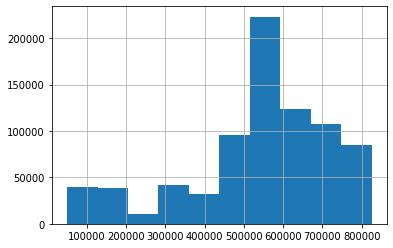

In [39]:
transactions['postalcode'].hist()

### Sanity check to see if postal code distribution makes sense, and I think it does; the central districts have less flats, hence less transactions recorded

In [40]:
transactions.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
tx_day                 0
full_address           0
postalcode             0
dtype: int64

## Here we have it, a clean dataset: cleaned and transformed where necessary, ready to be fed to your learner! This really was made way easier, because the dataset was very very clean to begin with, so kudos to our public service!

```python
pickleRick(transactions,'transactions.pickle')
#saving the transactions dataframe so you don't have to run the whole cleaning and transformation the next time you use it!
```

In [41]:
transactions.dtypes

month                  datetime64[ns]
town                           object
flat_type                      object
block                          object
street_name                    object
storey_range                    int64
floor_area_sqm                float64
flat_model                     object
lease_commence_date             int64
resale_price                  float64
remaining_lease                 int64
tx_day                          int64
full_address                   object
postalcode                    float64
dtype: object

## Time to choose the required features!

In [42]:
transactions['postalcode']=transactions['postalcode'].astype(str) #we are using postal code as a qualitative (nominal) data, instead of quantitative
features = ['town', #self explanatory
            'flat_type', #1 room or 3 room flat
            'storey_range', # which level the flat is at
            'floor_area_sqm', # how big the flat is
            'flat_model', # HDB flat model, affects the design of the flat
            'lease_commence_date', #year the flat was built in
            'remaining_lease', #remaining lease on the flat when it was transacted
            'tx_day', #date transacted in days from Jan 1990
            'postalcode' #self explanatory, represents the desirability of location in it's price
           ]

In [43]:
X = transactions[features]
y = transactions['resale_price']

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.dtypes #just a final check

town                    object
flat_type               object
storey_range             int64
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease          int64
tx_day                   int64
postalcode              object
dtype: object

In [45]:
X_train.shape #training on about 600k samples

(598297, 9)

In [46]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

### Using column transformer to select preprocessing for each column, makes preprocessing your features much simpler!
Categorical data will be OneHotEncoded, meaning a separate column will be created for every unique value in the categorical feature and the presence of a particular value will be indicated by a binary representation, 1 or 0.

Min/Max scaling is necessary here for our quantitative data as they are of different ranges: floor area is of order (of magnitude) $10^2$, lease_commence_date is of order $10^4$, tx_days: $10^5$, remaining lease: $10^2$, if not scaled, these features will have a disproportionate effect on our regression model.

In [47]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),['flat_type', 'flat_model','town', 'postalcode']),
                                       (MinMaxScaler(),['floor_area_sqm', 'lease_commence_date','storey_range','tx_day','remaining_lease']),
                                      remainder = 'passthrough')

### Ridge regression was chosen arbitrarily as a first model to be tested. Maybe more on different types of regularization next time!

In [48]:
pipe = make_pipeline(column_trans,Ridge())
cross_val_score(pipe, X_train,y = y_train, cv = 5).mean()

0.8393352551310389

In [49]:
from sklearn.metrics import median_absolute_error, mean_squared_error
pipe.fit(X_train, y_train)
score = pipe.score(X_test,y_test)
pred = pipe.predict(X_test)
MAE = median_absolute_error(y_test, pred)
MSE = mean_squared_error(y_test,pred)
RMSE = MSE**0.5

print('R2 value is: ',score)
print('Median Absolute Error is: ', MAE)
print('Root Mean Squared Error is: ', RMSE)

R2 value is:  0.839835120694272
Median Absolute Error is:  35695.34185631183
Root Mean Squared Error is:  59116.101606196215


### How do we interpret the scoring metric?

**R2 value**: Represents the goodness of fit, meaning **83.8%** of the variance in resale price can be explained by our regression model

**Median Absolute Error**: Quite literal, it is the median value of all the errors in the predicted test set, meaning the median sample predicted value is **\$35608** away from its actual transaction price

**Root Mean Squared Error**: Square root of the sum of all errors squared is **\$59065**

Maybe we can squeeze a little more performance by tuning the hyperparameters?

In [51]:
from sklearn.model_selection import GridSearchCV
a = np.logspace(-4,0,5)
param_grid = {
        'ridge__alpha': a,
}
grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=False)

In [52]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['flat_type',
                                                                          'flat_model',
                                                                          'town',
                                                                          'postalcode']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['floor_area_sqm',
                 

In [53]:
print('Best score: ',grid.best_score_)
print('Best parameter: ',grid.best_params_)

Best score:  0.8394484728749194
Best parameter:  {'ridge__alpha': 0.1}


In [54]:
grid.cv_results_

{'mean_fit_time': array([1.73369169, 1.74409423, 1.67041512, 1.68611798, 1.65473671]),
 'std_fit_time': array([0.04222505, 0.05825628, 0.0532609 , 0.01323466, 0.04335799]),
 'mean_score_time': array([0.21571207, 0.20829   , 0.20712953, 0.20508223, 0.20838943]),
 'std_score_time': array([0.00714536, 0.00654544, 0.00193993, 0.00104484, 0.00327818]),
 'param_ridge__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.0001},
  {'ridge__alpha': 0.001},
  {'ridge__alpha': 0.01},
  {'ridge__alpha': 0.1},
  {'ridge__alpha': 1.0}],
 'split0_test_score': array([0.84022929, 0.84009742, 0.84009768, 0.84011447, 0.84022598]),
 'split1_test_score': array([0.83989873, 0.83990114, 0.83936924, 0.83999921, 0.83946344]),
 'split2_test_score': array([0.83968983, 0.83968861, 0.83969236, 0.839706  , 0.83982616]),
 'split3_test_score': array([0.83878392, 0.83878594, 

### It seems like R2 scores are the same with more or less regularisation, it could signify that the data is high in bias (underfitting), due to the lack of features.
This is rather understandable as the total number of features passed into the model is 9 (although it is expanded to a 9000+ column sparse matrix after OneHotEncoding). Perhaps a deep neural network could give better performance, given that we have an abundance of samples and a lack of features. This is an idea worth exploring, perhaps for after I finish my online course on deep learning. 

### Final Words
Using some feature engineering and web scraping, we managed to come up with a rather decent linear regression model, it will not give the fair price of a particular flat, but at least it's a nice guide! Feature coefficients (model.coef_) can also give us a good guide on what are the more important features the affect the resale price of a flat. 

This project has been fun and it is definitely a handy tool to use when shopping for your first HDB flat. This model is currently deployed [here](https://whatsmyhdbprice.herokuapp.com/). I hope this is the first of many fun projects I'll be sharing with you. Your feedback is always welcome; just leave me a message on my github!